<a href="https://colab.research.google.com/github/lmn190104/yolov5-AI/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Codegit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17493, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 17493 (delta 2), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17493/17493), 16.56 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (11997/11997), done.


In [3]:
!pip install --quiet opencv-python-headless torch torchvision

import os
import cv2
import torch
import numpy as np
import glob
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00


In [4]:
# --------- 1. Hàm xử lý ảnh và nhãn ------------
def preprocess_image_and_label(img_path, label_path, img_size=416):
    # Load và resize ảnh
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_tensor = transforms.ToTensor()(img)  # [C, H, W], giá trị [0,1]

    # Đọc nhãn định dạng YOLO: class_id x_center y_center width height (tính theo tỉ lệ)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        labels.append(parts)

    label_tensor = torch.tensor(labels)  # [num_objects, 5]
    return img_tensor, label_tensor

In [5]:
class YoloDataset(Dataset):
    def __init__(self, image_paths, labels_folder, transform=None):
        self.image_paths = image_paths
        self.labels_folder = labels_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.labels_folder, file_name + '.txt')

        img_tensor, label_tensor = preprocess_image_and_label(img_path, label_path)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor


In [6]:
# Đường dẫn dữ liệu
images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images/'
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels/'

# Tạo dataset
dataset = YoloDataset(images_folder, labels_folder)

# Tạo dataloader với batch_size phù hợp RAM
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [7]:
from sklearn.model_selection import train_test_split
import glob, os

# Lấy danh sách ảnh
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# Chia train/val
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# Tạo dataset và dataloader
train_dataset = YoloDataset(train_paths, labels_folder)
val_dataset = YoloDataset(val_paths, labels_folder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [8]:
import os
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import glob

# ==== 1. Cấu hình đường dẫn gốc ====

images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images'  # <-- chỉnh đường dẫn này
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels' # <-- chỉnh đường dẫn này

output_base = '/content/yolov5/data_cleaned'  # <-- nơi lưu tập dữ liệu sau khi chia

# ==== 2. Lấy tất cả ảnh ====
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# ==== 3. Chia train / val ====
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# ==== 4. Tạo thư mục cần thiết ====
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_base, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, 'labels'), exist_ok=True)

# ==== 5. Hàm sao chép ảnh & nhãn ====
def copy_data(image_paths, split):
    for img_path in tqdm(image_paths, desc=f'Copying {split} data'):
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_folder, file_name + '.txt')

        # Đích đến
        img_dest = os.path.join(output_base, split, 'images', os.path.basename(img_path))
        label_dest = os.path.join(output_base, split, 'labels', file_name + '.txt')

        # Copy ảnh
        if os.path.exists(img_path):
            shutil.copy(img_path, img_dest)

        # Copy nhãn
        if os.path.exists(label_path):
            shutil.copy(label_path, label_dest)
        else:
            print(f"[!] Thiếu nhãn: {label_path}")

# ==== 6. Thực hiện copy ====
copy_data(train_paths, 'train')
copy_data(val_paths, 'val')


Copying val data: 100%|██████████| 448/448 [04:42<00:00,  1.59it/s]


In [9]:
yaml_contentt = """
train: /content/yolov5/data_cleaned/train
val: /content/yolov5/data_cleaned/val

nc: 5
names: ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']
"""

with open('datalmn.yaml', 'w') as f:
    f.write(yaml_contentt)



In [10]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 50 --data /content/datalmn.yaml --weights yolov5s.pt --cache


Streaming output truncated to the last 5000 lines.
      28/49      4.14G    0.02015    0.02328    0.00373        140        640:  23% 26/112 [00:19<01:16,  1.12it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      4.14G    0.02026    0.02325   0.003724        110        640:  24% 27/112 [00:20<01:27,  1.03s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      4.14G    0.02025    0.02313   0.003742        107        640:  25% 28/112 [00:21<01:08,  1.22it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      28/49      4.14G     0.0203 

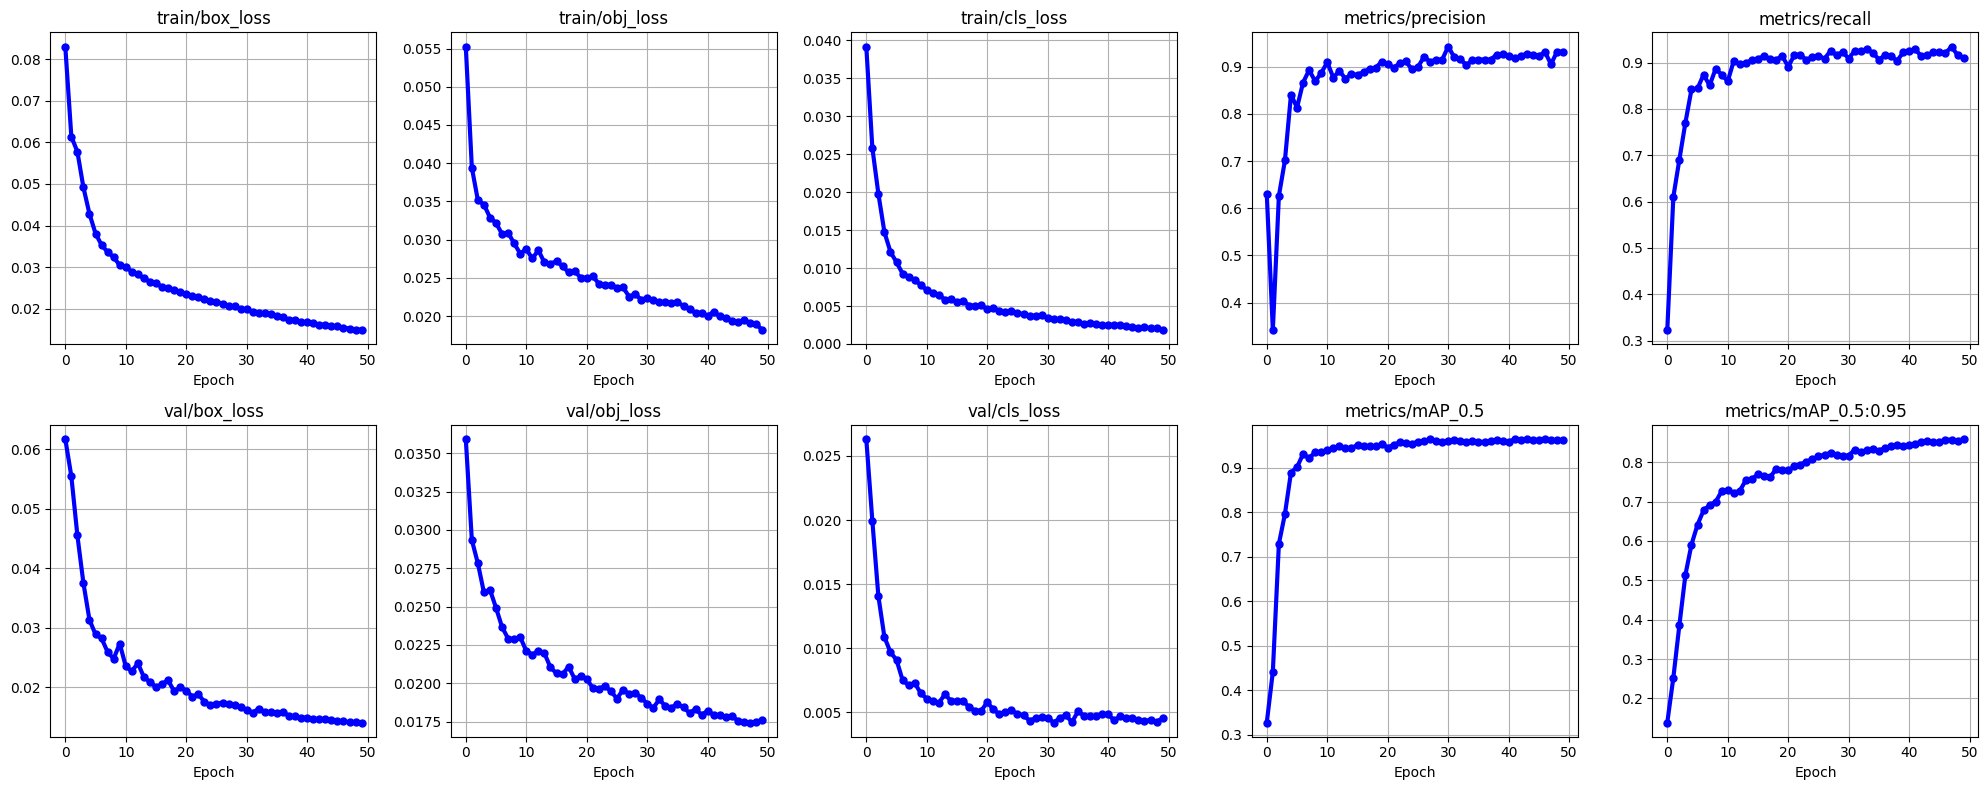

In [21]:
#Biểu đồ train 50 epochs

!pip install matplotlib pandas

# 1. Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Đọc file CSV (thay đường dẫn nếu bạn đã đổi tên hoặc vị trí)
csv_path = '/content/yolov5/runs/train/exp/results.csv'  # hoặc đường dẫn tới file bạn upload
df = pd.read_csv(csv_path)

# 3. Làm sạch tên cột (xóa khoảng trắng đầu/cuối)
df.columns = df.columns.str.strip()

# 4. Danh sách metric cần vẽ
metrics = [
    'train/box_loss', 'train/obj_loss', 'train/cls_loss',
    'metrics/precision', 'metrics/recall',
    'val/box_loss', 'val/obj_loss', 'val/cls_loss',
    'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95'
]

# 5. Vẽ biểu đồ 2 hàng x 5 cột
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, metric in enumerate(metrics):
    row, col = divmod(i, 5)
    axs[row][col].plot(
        df[metric],
        color='blue',
        linewidth=3,
        marker='o',
        markersize=5
    )
    axs[row][col].set_title(metric, fontsize=12)
    axs[row][col].set_xlabel('Epoch')
    axs[row][col].grid(True)

plt.tight_layout()
plt.show()

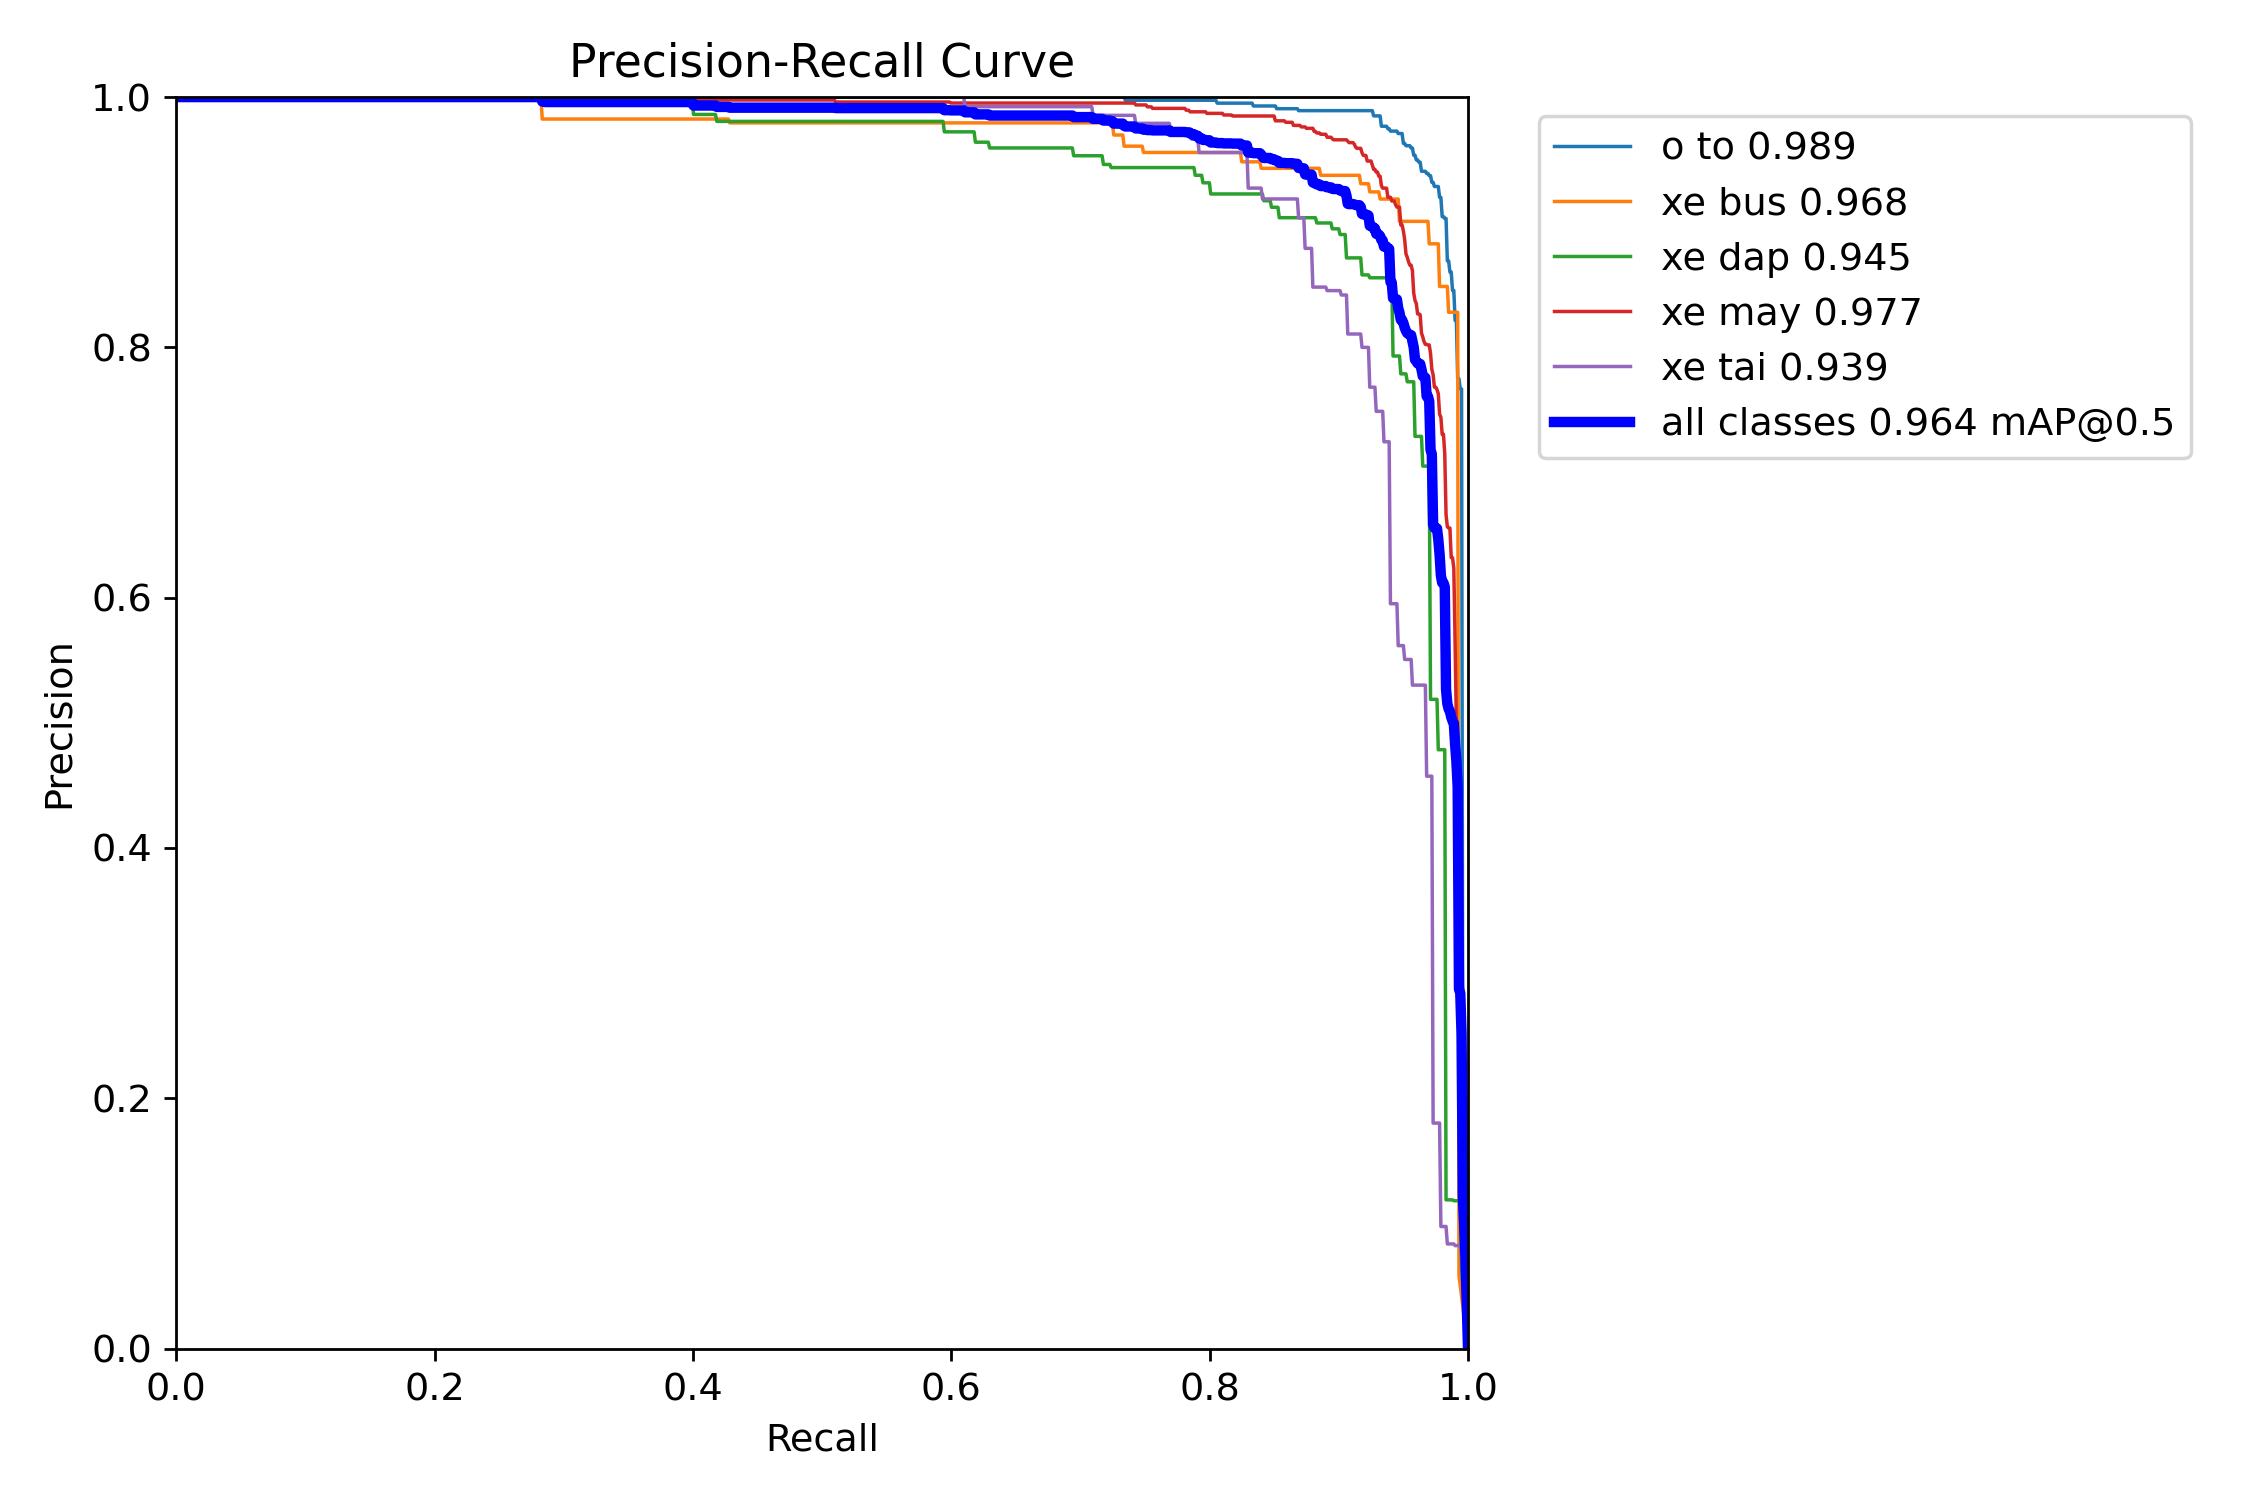

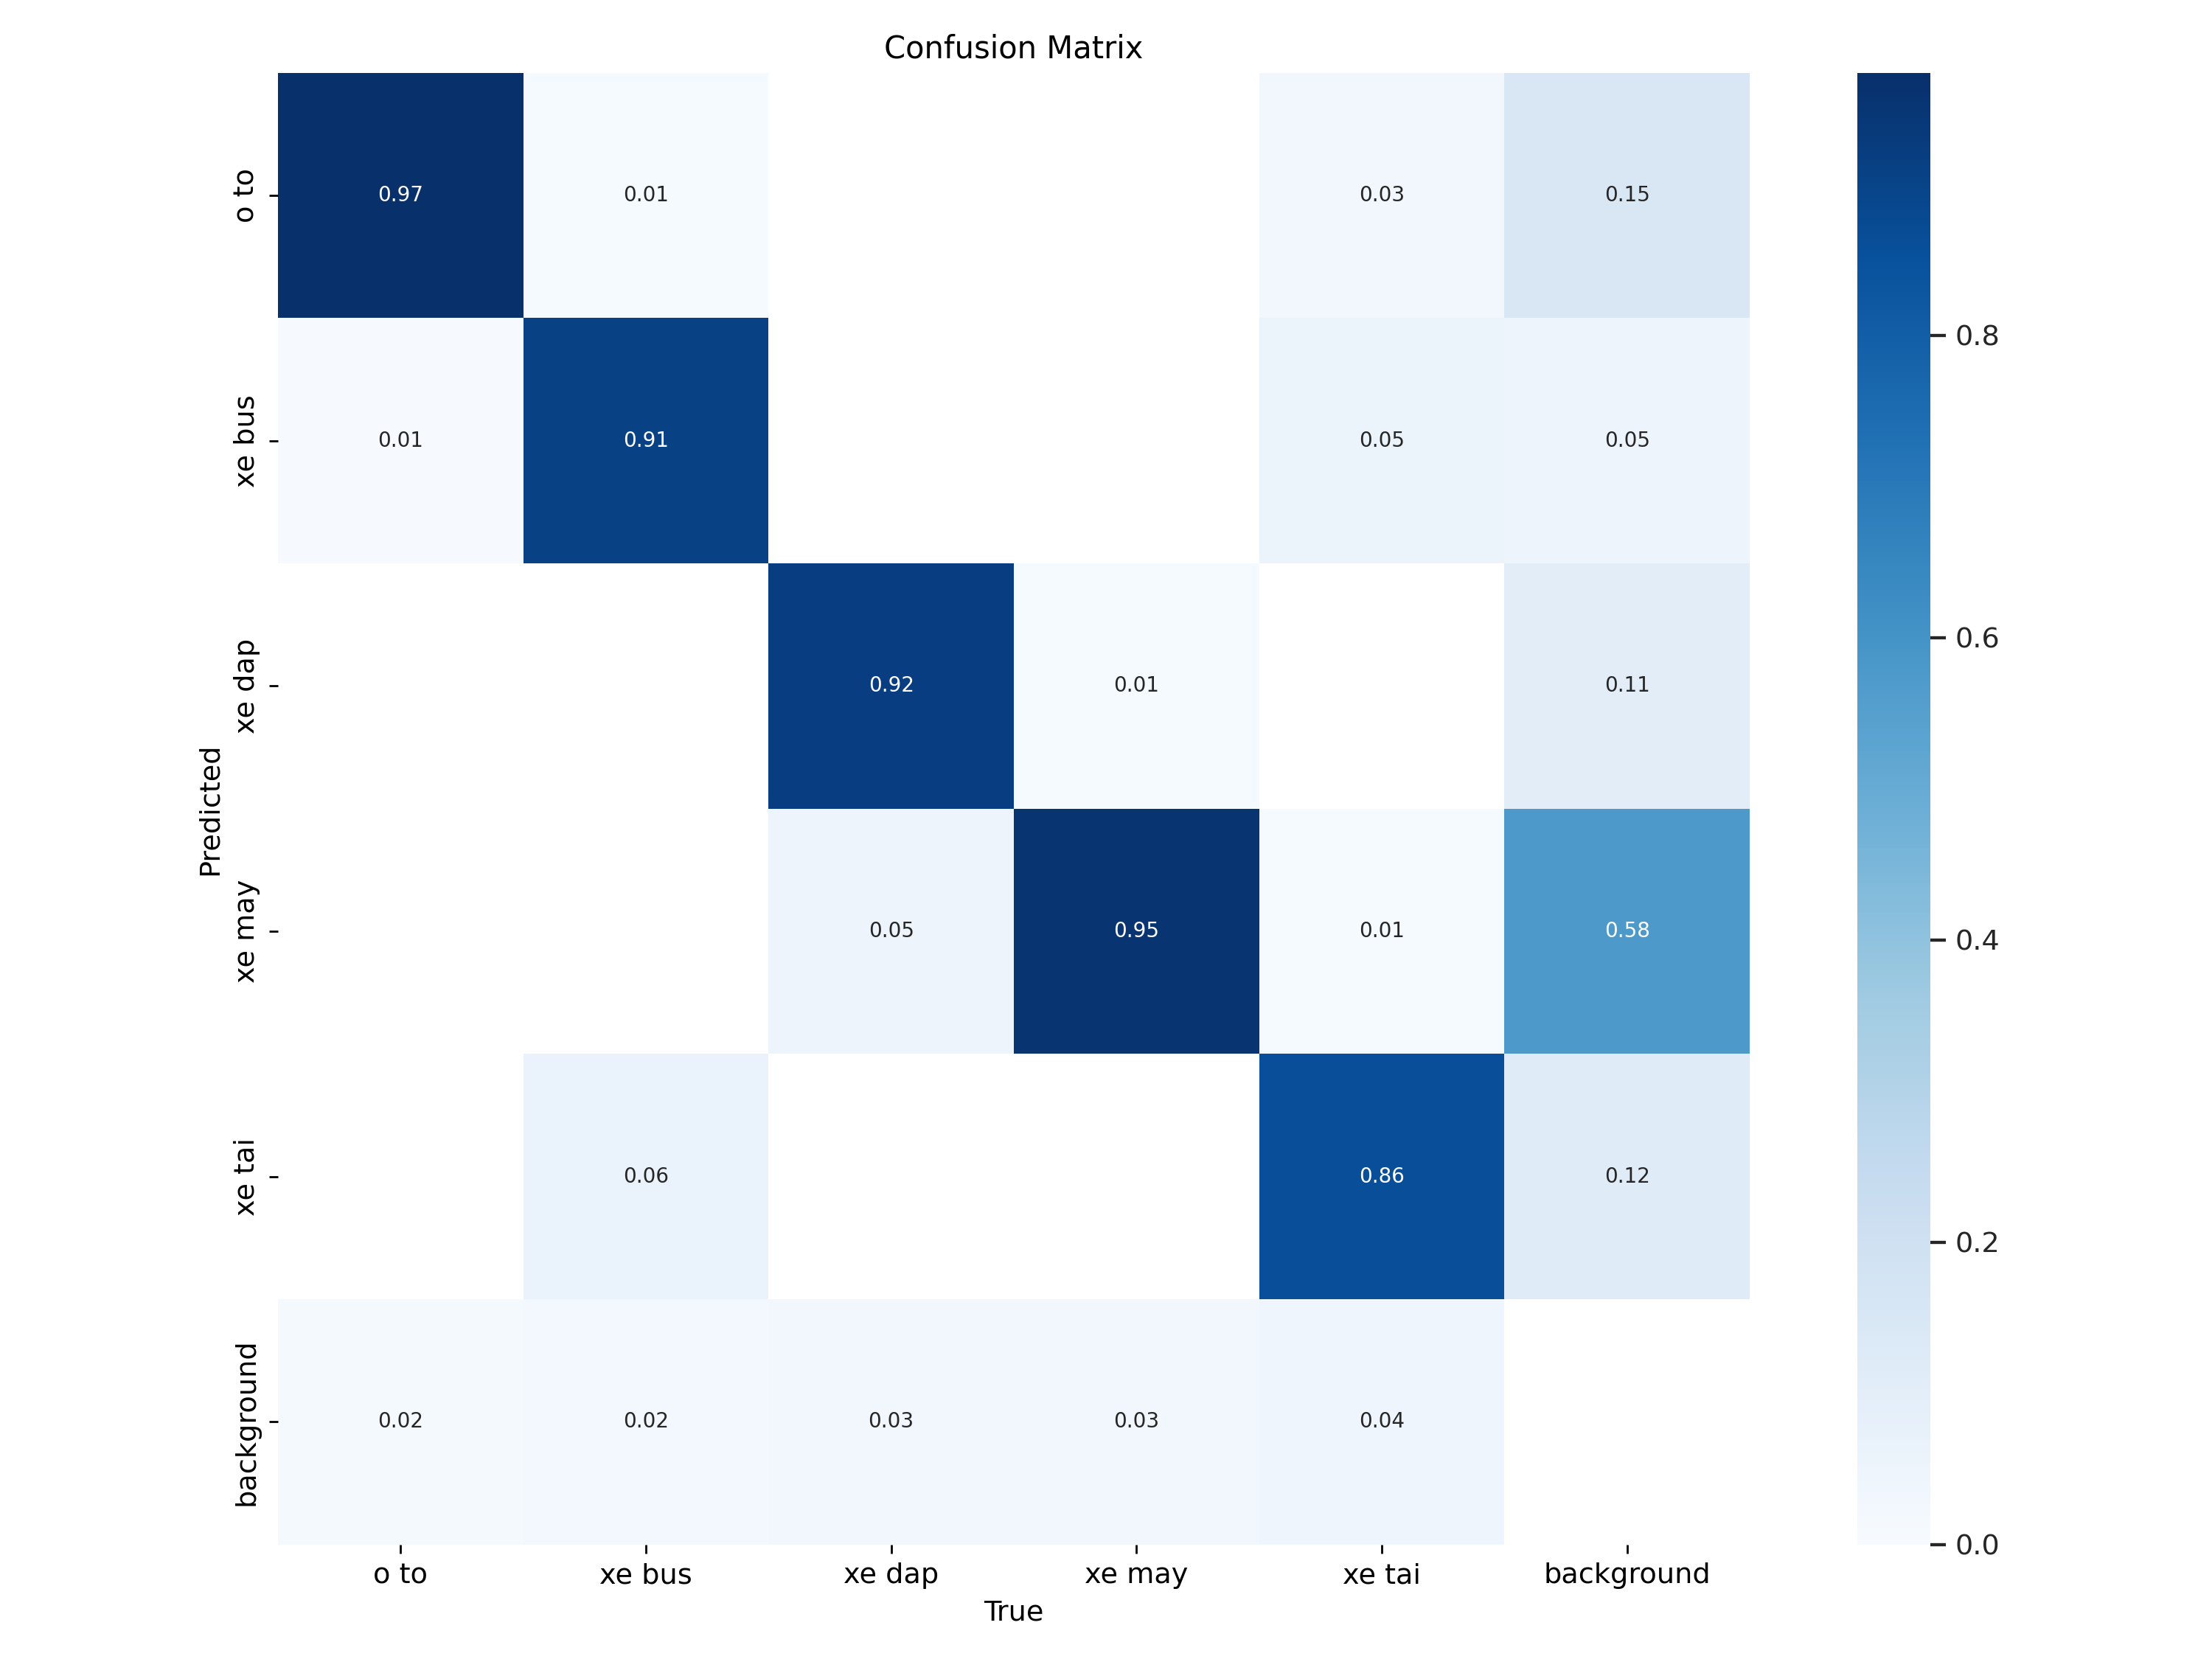

In [22]:
#Biểu đồ Precision - Recall Curve và Biểu đồ Confusion Matrix

from IPython.display import Image, display

display(Image('/content/yolov5/runs/train/exp/PR_curve.png', width=500))
display(Image('/content/yolov5/runs/train/exp/confusion_matrix.png', width=500))

In [11]:
!python /content/yolov5/detect.py --source /content/yolov5/data/images --weights /content/yolov5/runs/train/exp2/weights/best.pt --conf 0.25 --save-txt

detect: weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 438, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 433, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/co

In [12]:
import glob
from IPython.display import Image, display

# Lấy danh sách ảnh kết quả
result_images = glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640
for img_path in result_images[:1]:
    display(Image(filename=img_path, height=640))


In [13]:
import glob
from IPython.display import Image, display
import os

# Định nghĩa danh sách các nhãn vi phạm
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']

# Đường dẫn tới thư mục chứa kết quả phát hiện
detect_folder = '/content/yolov5/runs/detect/exp3'

# Hàm kiểm tra xem ảnh có chứa nhãn vi phạm không
def analyze_objects(label_path, class_names, violation_classes):
    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        return False

    with open(label_path, 'r') as f:
        lines = f.readlines()

    violated = 0

    print(f"\n[🔍] Kiểm tra: {os.path.basename(label_path).replace('.txt', '')}")
    for idx, line in enumerate(lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = class_names[class_id]

        if class_name in violation_classes:
            print(f"→ Object {idx}: {class_name:<8} ❌ VI PHẠM")
            violated += 1
        else:
            print(f"→ Object {idx}: {class_name:<8} ✔️ Hợp lệ")

    print(f"✅ Tổng cộng {violated} VI PHẠM trong ảnh")
    return violated > 0


# Danh sách tên class từ file YAML
class_names = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']

# Lấy danh sách ảnh kết quả
result_images = glob.glob(os.path.join(detect_folder, '*.jpg'))

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640 và kiểm tra vi phạm
for img_path in result_images[:3]:
    file_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(detect_folder, 'labels', file_name + '.txt')

    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        continue

    print(f"\n[🔍] Kiểm tra: {file_name}")
    with open(label_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        class_id = int(line.split()[0])
        class_name = class_names[class_id]
        print(f" → Phát hiện object: {class_name}")

    if analyze_objects(label_path, class_names, VIOLATION_CLASSES):
      print(f"Ảnh {os.path.basename(img_path)} ✅ VI PHẠM")
    else:
      print(f"Ảnh {os.path.basename(img_path)} ❎ KHÔNG vi phạm")

# Hiển thị ảnh___
    display(Image(filename=img_path, width=640, height=640))


In [14]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


In [15]:
!ngrok config add-authtoken 2ySj3AFJkUvLncuFN4De21GCJ6T_3vuGhUJ2QejZVG9dYmAjM


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [16]:
%%writefile app.py
import streamlit as st
import torch
from PIL import Image
import os
import tempfile
import numpy as np
import cv2
# Danh sách lớp phương tiện
CLASS_NAMES = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']

@st.cache_resource(show_spinner=True)
def load_model():
    model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/exp2/weights/best.pt', source='local')
    return model

model = load_model()

st.title("🚦 Nhận diện phương tiện vi phạm giao thông")
st.write("Tải ảnh lên để nhận diện: o to, xe bus, xe dap, xe may, xe tai")

uploaded_file = st.file_uploader("📤 Chọn ảnh...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Ảnh gốc', use_container_width=True)

    with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp_file:
        tmp_path = tmp_file.name
        image.save(tmp_path)

    results = model(tmp_path)
    results.render()

    result_img = Image.fromarray(cv2.cvtColor(results.ims[0], cv2.COLOR_BGR2RGB))
    st.image(result_img, caption='Kết quả dự đoán', use_container_width=True)

    detections = results.pandas().xyxy[0]

    st.write("### Kết quả chi tiết:")
    violated = 0

    for idx, row in detections.iterrows():
        class_name = row['name']
        confidence = row['confidence']
        st.write(f"- Đối tượng {idx + 1}: `{class_name}` - Độ tin cậy: {confidence:.2f}")
        if class_name in VIOLATION_CLASSES:
            violated += 1

    if violated > 0:
        st.error(f"⛔ Phát hiện {violated} phương tiện vi phạm!")
    else:
        st.success("✅ Không phát hiện vi phạm.")


Writing app.py


In [17]:
%%writefile run.py
import os
import threading
from pyngrok import ngrok

# Mở cổng 8501 cho Streamlit
public_url = ngrok.connect(port=8501)
print("Ngrok URL:", public_url)

# Chạy streamlit app
os.system("streamlit run app.py")


Writing run.py


In [18]:
from pyngrok import ngrok
import os
import time

# Chạy Streamlit app ở nền
os.system("streamlit run app.py &")
time.sleep(3)  # chờ Streamlit khởi động

# Tạo tunnel ngrok với proto và địa chỉ rõ ràng
public_url = ngrok.connect(addr="8501", proto="http")
print("🌍 App URL:", public_url)


🌍 App URL: NgrokTunnel: "https://6e24-34-143-137-120.ngrok-free.app" -> "http://localhost:8501"


In [19]:
#nếu bị ghi đè thì chạy hai lệnh này
!ls -l app.py
!cat app.py

-rw-r--r-- 1 root root 1771 Jun 14 11:08 app.py
import streamlit as st
import torch
from PIL import Image
import os
import tempfile
import numpy as np
import cv2
# Danh sách lớp phương tiện
CLASS_NAMES = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']

@st.cache_resource(show_spinner=True)
def load_model():
    model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/exp2/weights/best.pt', source='local')
    return model

model = load_model()

st.title("🚦 Nhận diện phương tiện vi phạm giao thông")
st.write("Tải ảnh lên để nhận diện: o to, xe bus, xe dap, xe may, xe tai")

uploaded_file = st.file_uploader("📤 Chọn ảnh...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Ảnh gốc', use_container_width=True)

    with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp_file:
        tmp_path = tmp_file.name
        image.save(tmp_path)

  

In [20]:
!pkill streamlit